https://support.zemax.com/hc/en-us/articles/4406838460819-Modelling-of-a-Shack-Hartmann-Sensor-for-eye-aberration-evaluation  
https://support.zemax.com/hc/en-us/articles/1500005575422-How-to-model-a-black-box-optical-system-using-Zernike-coefficients


In [1]:
import os 
import sys
import h5py
path = os.path.dirname(os.path.dirname(os.path.realpath("__file__")))
sys.path.insert(0,path)

import numpy as np
import matplotlib.pyplot as plt
import LightPipes as lp
from skimage.restoration import unwrap_phase
from utils.api_functions import *
from utils.opt_functions import *
from shack_hartmann.sh_functions import *



%run -i "\\alfs1.physics.ox.ac.uk\al\howards\Zemax\ZOS-API Projects\PythonZOSConnection\PythonZOSConnection.py"
fast_system(TheSystem) # this speeds up the program.

Found OpticStudio at:   %sc:\program files\zemax opticstudio
Connected to OpticStudio
Serial #:  L121911


First I create a file that I will manually upload to zemax. This sets n_zernikes

In [2]:
n_zernikes = 45
zernike_surf = TheSystem.LDE.GetSurfaceAt(1)
zernike_surf.SurfaceData.NumberOfTerms = n_zernikes
zernike_surf.SurfaceData.NormRadius = 7
# generate_zernike_file(zernike_coeffs,radius = 5) #here i create a file that can be read into zemax.

In [3]:
# Generate abberations
main_aberration = np.round(n_zernikes*np.random.rand(1))
# design aberrations not enrirely random but to lie around a main aberration
zernike_coeffs = np.random.rand(n_zernikes)/(1+np.abs(np.arange(0,n_zernikes,1)-main_aberration))**(2*np.random.rand(1))


set_zernikes(ZOSAPI, zernike_surf, n_zernikes,zernike_coeffs)

In [5]:
Nx = 1024

image = get_spots(ZOSAPI,TheSystem,Nx) # get spot pattern
wavefront = get_wavefront(ZOSAPI,TheSystem,Nx) # get wavefront

Prove its proportional to the LightPipes one...

In [9]:
new_coeffs = rot_zern_coeffs(old_coeffs = zernike_coeffs,rotation_deg = 180)
N = Nx
size = N * 150*lp.um
λ  = 750*lp.nm
F=lp.Begin(size,λ  ,N) # initiate


for Noll in range(1, n_zernikes+1):
        (nz, mz) = lp.noll_to_zern(Noll) #converting between int and zernike coeffs
        e_m = 2 if mz == 0 else 1
        A = 1
        F = lp.Zernike(F, nz, mz, size, new_coeffs[Noll-1] * A, units='lam')

F_ideal=lp.CircAperture(F,size/2)

wavefront2 = unwrap_phase(np.angle(F_ideal.field))


x, y  = np.linspace(-1,1,N),np.linspace(-1,1,N)

xx,yy = np.meshgrid(x,y)
r = np.sqrt(xx**2 + yy**2)
wavefront2[r>1] = 0

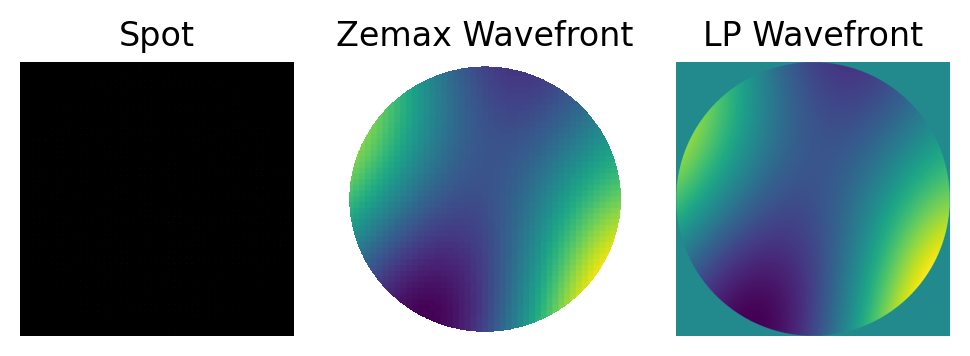

In [11]:
%matplotlib inline
fig,ax = plt.subplots(1,3,dpi=200)
ax[0].imshow(image,cmap='Greys_r');ax[0].set_title('Spot');ax[0].set_axis_off()
ax[1].imshow(wavefront);ax[1].set_title('Zemax Wavefront');ax[1].set_axis_off()
ax[2].imshow(wavefront2);ax[2].set_title('LP Wavefront');ax[2].set_axis_off()